In [1]:
import numpy as np

# Define a signal function that generates random values based on a function
def signal_function(x):
    min_val, max_val = np.sin(x) + x * np.sin(x), 20
        # Define circular region parameters
    center_x, center_y = 0, 10  # Center coordinates
    radius = 3  # Radius
    y_test = np.random.uniform(low=min_val, high=max_val, size=(1,))
    if (np.isnan(y_test)):
        print(y_test)
    # Check if the point (x, y) is outside the circular region
    if (x - center_x)**2 + (y_test - center_y)**2 > radius**2:
        return y_test
    else:
        return np.random.uniform(low=15, high=20, size=(1,))

# Define a background function that generates random values based on a function
def background_function(x):
    min_val, max_val = np.sin(x) + x * np.sin(x), 20
        # Define circular region parameters
    center_x, center_y = 0, 10  # Center coordinates
    radius = 4  # Radius
    y_test = np.random.uniform(low=min_val, high=max_val, size=(1,))
    if (x - center_x)**2 + (y_test - center_y)**2 < radius**2:
        return y_test
    else:
        min_val, max_val = -20, np.sin(x) + x * np.sin(x)  
        y_test = np.random.uniform(low=min_val, high=max_val, size=(1,))
        return y_test

# Generate synthetic data for signal and background
data_size = 3000

# Generate signal data
signal_x = np.random.uniform(low=-11.0, high=10.0, size=(data_size,))
signal_y = np.zeros(data_size, dtype=float)
signal_label = np.ones(data_size)
for count, x in enumerate(signal_x):
    signal_y[count] = signal_function(x)
signal_data = np.column_stack((signal_x, signal_y, signal_label))

# Generate background data
background_x = np.random.uniform(low=-11.0, high=10.0, size=(data_size,))
background_y = np.zeros(data_size, dtype=float)
background_label = np.zeros(data_size)
for count, x in enumerate(background_x):
    background_y[count] = background_function(x)
background_data = np.column_stack((background_x, background_y, background_label))

/var/folders/h1/s46zdkz905j6q1vd7vxjj6v40000gn/T/ipykernel_38509/1601934543.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  signal_y[count] = signal_function(x)
/var/folders/h1/s46zdkz905j6q1vd7vxjj6v40000gn/T/ipykernel_38509/1601934543.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  background_y[count] = background_function(x)


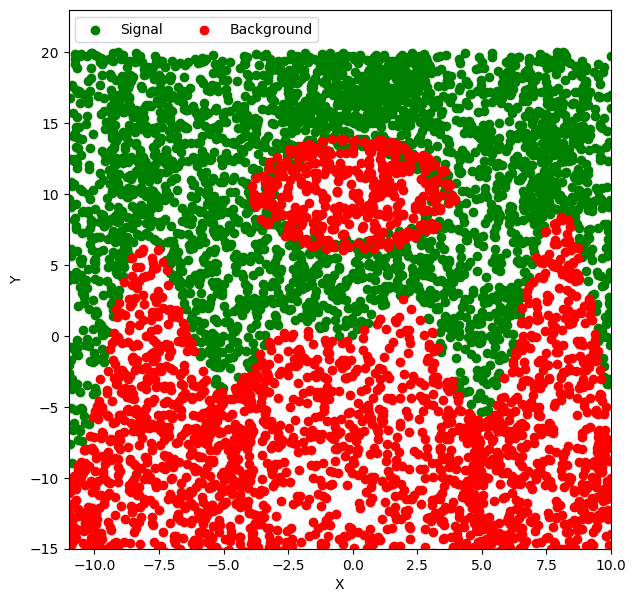

In [2]:
import matplotlib.pyplot as plt

# Plot the actual data points along with the actual function and estimated line
plt.figure(1, figsize=(7, 7))
plt.scatter(signal_data[:, 0], signal_data[:, 1], color='green', label="Signal")
plt.scatter(background_data[:, 0], background_data[:, 1], color='red', label="Background")
plt.legend(loc="upper left", ncol=4)
plt.xlim(-11, 10)
plt.ylim(-15, 23)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


signal_label = np.ones(len(signal_data))
signal_data = np.column_stack((signal_data, signal_label))

background_label = np.zeros(len(background_data))
background_data = np.column_stack((background_data, background_label))

# Concatenate signal and background data
full_data = np.vstack((signal_data, background_data))

# Shuffle the data
np.random.shuffle(full_data)

# Split data into features (X) and labels (y)
X = full_data[:, :2]  # Features (x, y)
Y = full_data[:, 2]   # Labels (1 for signal, 0 for background)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# default: max_depth=2, min_samples_split=2
DTC = DecisionTreeClassifier(max_depth=3,min_samples_split=20)
BDT = AdaBoostClassifier(estimator=DTC,n_estimators=150,algorithm = 'SAMME')

# Train the BDT! One line, very fast
model = BDT.fit(X_train, y_train) # BDT looks at each feature independently, so scaling is typically not necessary

# BDT scores
y_prob_test = model.decision_function(X_test)
# Prediction
y_pred_test = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy: {accuracy * 100:.3f}%")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 95.000%
Confusion Matrix:
[[538  26]
 [ 34 602]]


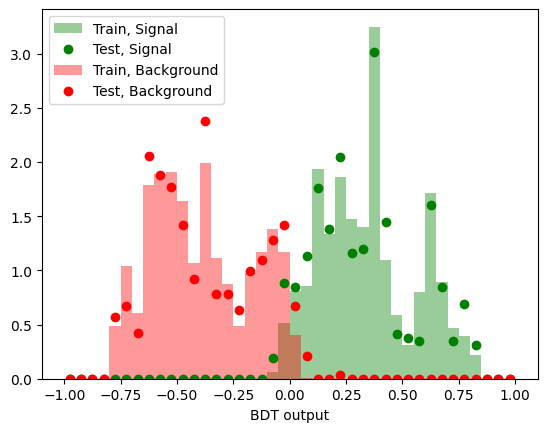

In [4]:
# Extract decision function outputs for signal and background classes in the training set
y_pred_signal_train = model.decision_function(X_train[y_train==1])
y_pred_signal_test = model.decision_function(X_test[y_test==1])
y_pred_background_train = model.decision_function(X_train[y_train==0])
y_pred_background_test = model.decision_function(X_test[y_test==0])

# Set the number of bins, range, and other parameters for the histogram
n_bins = 40
hist_range = (-1.0, 1.0)

# Plot histogram for the signal class in the training set
plt.hist(y_pred_signal_train, bins=n_bins, range=hist_range, density=True, alpha=0.4, color='green', label="Train, Signal")

# Plot histogram for the signal class in the test set
counts, bin_edges = np.histogram(y_pred_signal_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color='green', label="Test, Signal")

# Plot histogram for the background class in the training set
plt.hist(y_pred_background_train, bins=n_bins, range=hist_range, density=True, alpha=0.4, color='red', label="Train, Background")

# Plot histogram for the background class in the test set
counts, bin_edges = np.histogram(y_pred_background_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color='red', label="Test, Background")

# Add legend and labels to the plot
plt.legend()
plt.xlabel('BDT output')

# Show the plot
plt.show()

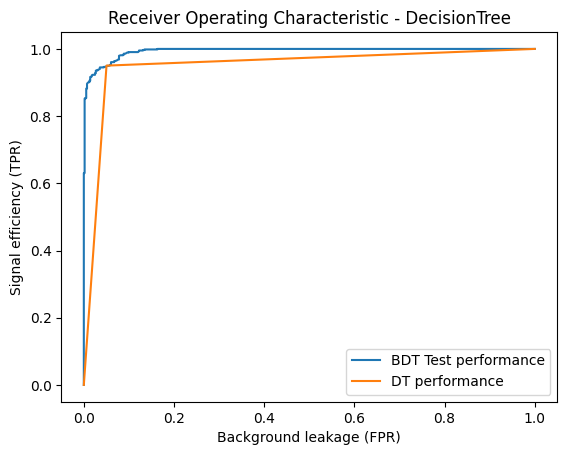

In [5]:
from sklearn.metrics import roc_curve

# Previous study False Positive Rate (FPR) and True Positive Rate (TPR) for the Decision Tree (DT) model
DT_FPR = [0., 0.05033557, 1.]
DT_TPR = [0., 0.95033113, 1.]

# Compute ROC curve for the Boosted Decision Tree (BDT) model using the test set
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y_test, y_prob_test, pos_label=1)

# Plot the ROC curve for the BDT model
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT Test performance")

# Plot the pre-defined ROC curve for the Decision Tree (DT) model
plt.plot(DT_FPR, DT_TPR, label="DT performance")

# Add title and axis labels to the plot
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

# Add legend to the plot
plt.legend(loc="lower right")

# Show the plot
plt.show()

[Text(0.5, 0.875, 'x[1] <= -4.082\ngini = 0.499\nsamples = 4800\nvalue = [0.479, 0.521]'),
 Text(0.25, 0.625, 'x[0] <= -10.364\ngini = 0.151\nsamples = 1703\nvalue = [0.116, 0.01]'),
 Text(0.125, 0.375, 'x[1] <= -8.946\ngini = 0.461\nsamples = 78\nvalue = [0.012, 0.007]'),
 Text(0.0625, 0.125, 'gini = -0.0\nsamples = 66\nvalue = [0.011, 0.0]'),
 Text(0.1875, 0.125, 'gini = 0.05\nsamples = 12\nvalue = [0.0, 0.007]'),
 Text(0.375, 0.375, 'x[1] <= -5.384\ngini = 0.068\nsamples = 1625\nvalue = [0.104, 0.004]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 1499\nvalue = [0.086, 0.0]'),
 Text(0.4375, 0.125, 'gini = 0.29\nsamples = 126\nvalue = [0.018, 0.004]'),
 Text(0.75, 0.625, 'x[0] <= 6.731\ngini = 0.486\nsamples = 3097\nvalue = [0.364, 0.51]'),
 Text(0.625, 0.375, 'x[0] <= -6.241\ngini = 0.457\nsamples = 2624\nvalue = [0.251, 0.462]'),
 Text(0.5625, 0.125, 'gini = 0.466\nsamples = 657\nvalue = [0.098, 0.058]'),
 Text(0.6875, 0.125, 'gini = 0.398\nsamples = 1967\nvalue = [0.153, 0.404]'),

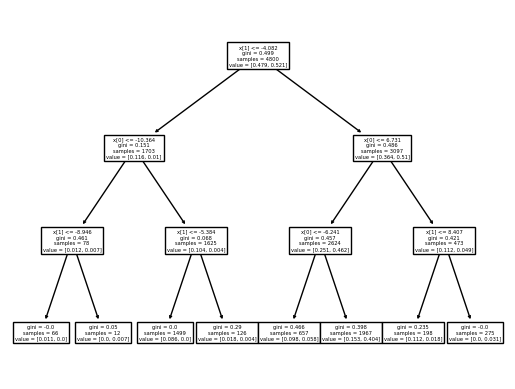

In [6]:
# Extract the decision tree at index 3 from the ensemble model
DT_0 = model.estimators_[3]

# Visualize the structure of the decision tree using the plot_tree function
tree.plot_tree(DT_0)

Text(0.5, 0, 'X')

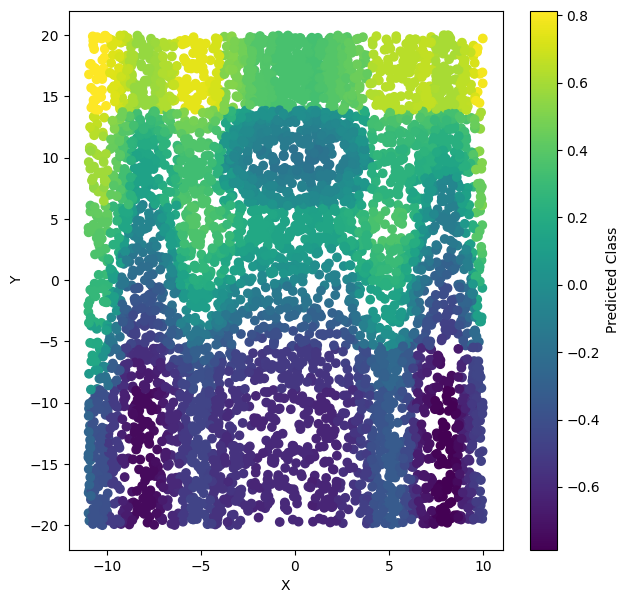

In [7]:
# Set the figure size for the scatter plot
plt.figure(figsize=(7, 7))

# Obtain the decision function scores for all samples in the dataset
y_pred_all = model.decision_function(X)

# Create a scatter plot with decision function scores as color
scatter = plt.scatter(X[:, 0], X[:, 1], c=y_pred_all, cmap='viridis')

# Add a color bar to the plot to indicate the predicted class based on decision function scores
plt.colorbar(scatter, label='Predicted Class')

# Set labels for the axes
plt.ylabel('Y')
plt.xlabel('X')

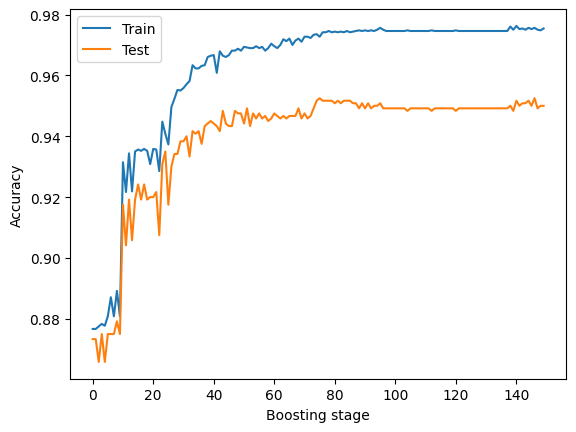

In [8]:
# Initialize empty lists to store training and testing accuracy at each boosting stage
test_acc, train_acc = [], []

# Iterate through each boosting stage and collect accuracy scores for training set predictions
for train_predict in model.staged_predict(X_train):
    train_acc.append(accuracy_score(train_predict, y_train))
    
# Iterate through each boosting stage and collect accuracy scores for test set predictions
for test_predict in model.staged_predict(X_test):
    test_acc.append(accuracy_score(test_predict, y_test)) 

# Plot the training and testing accuracy over boosting stages
plt.plot(train_acc, label="Train")  # Plot training accuracy
plt.plot(test_acc, label="Test")    # Plot testing accuracy
plt.xlabel("Boosting stage")         # Label for the x-axis
plt.ylabel("Accuracy")               # Label for the y-axis
plt.legend()                         # Add legend to distinguish between training and testing accuracy
plt.show()


[0.963] [0.01933333] [0.00333867]


/var/folders/h1/s46zdkz905j6q1vd7vxjj6v40000gn/T/ipykernel_38509/3880752014.py:20: RuntimeWarning: invalid value encountered in divide
  metric = S / np.sqrt(S + B)


<Figure size 500x500 with 0 Axes>

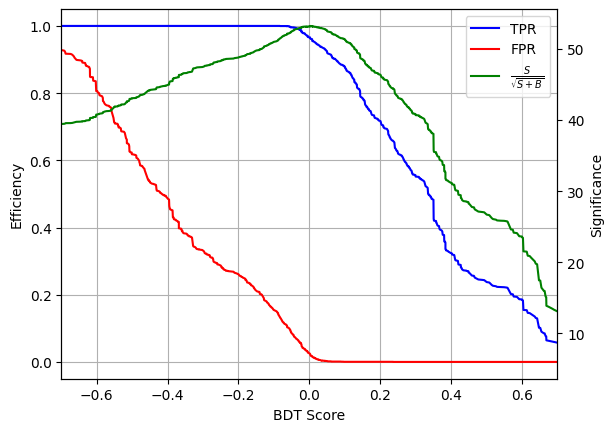

In [9]:
# Obtain decision function scores for all samples in the dataset
y_predict = model.decision_function(X)

# Extract true labels from the dataset
y_data = Y

# Determine the event sizes for signal and background classes
signal_eventsize = len(X[Y == 1])
background_eventsize = len(X[Y == 0]) 

# Compute ROC curves for both signal and background classes
signal_FPR, signal_TPR, signal_BDT_Score = roc_curve(y_data, y_predict, pos_label=1)  # Signal class set to 1
background_FPR, background_TPR, background_BDT_Score = roc_curve(y_data, y_predict, pos_label=0)  # Background class set to 0

# Calculate the Signal (S) and Background (B) contributions for significance metric
S = signal_eventsize * signal_TPR
B = background_eventsize * signal_FPR

# Calculate the significance metric S / sqrt(S + B) at each BDT score
metric = S / np.sqrt(S + B)

# Find the maximum significance and corresponding signal and background efficiencies and BDT score cut
max_metric = np.nanmax(metric)
signal_eff_max_metric = signal_TPR[np.where(metric == np.nanmax(metric))]
background_eff_max_metric = signal_FPR[np.where(metric == np.nanmax(metric))]
score_cut = signal_BDT_Score[np.where(metric == np.nanmax(metric))]

# Print the results
print(signal_eff_max_metric, background_eff_max_metric, score_cut)

# Create a plot to visualize the ROC curve, signal and background efficiencies, and significance metric
plt.figure(figsize=(5, 5))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel('BDT Score')
ax1.set_ylabel('Efficiency')
ax2.set_ylabel('Significance')

# Plot the True Positive Rate (TPR) and False Positive Rate (FPR) on the left y-axis
lns1 = ax1.plot(signal_BDT_Score, signal_TPR, 'b-', label="TPR")
lns2 = ax1.plot(signal_BDT_Score, signal_FPR, 'r-', label="FPR")

# Plot the significance metric on the right y-axis
lns3 = ax2.plot(signal_BDT_Score, metric, 'g-', label='$\\frac{S}{\\sqrt{S+B}}$')

# Add gridlines to the plot
ax1.grid()

# Combine all lines and labels for legend
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

# Set x-axis limits for better visualization
plt.xlim(-0.7, 0.7)

# Display the plot
plt.show()

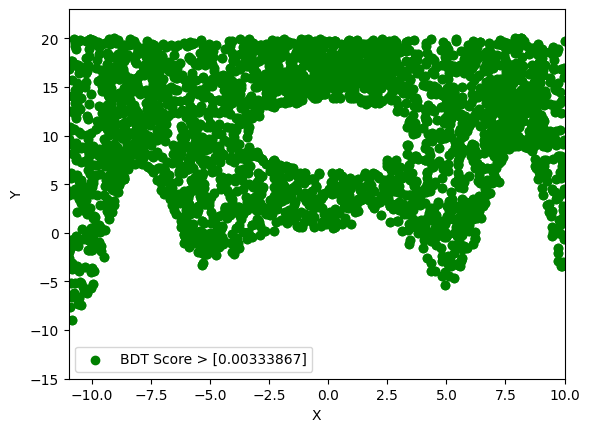

In [10]:
# Concatenate original features (X), true labels (Y), and predicted decision function scores (y_predict)
analyzed_data = np.hstack((X, Y.reshape(-1, 1)))
analyzed_data = np.hstack((analyzed_data, y_predict.reshape(-1, 1)))

# Select rows where the decision function score is greater than the previously determined score cut
selected_rows = analyzed_data[analyzed_data[:, 3] > score_cut]

# Create a scatter plot with selected rows, highlighting them in green
scatter = plt.scatter(selected_rows[:, 0], selected_rows[:, 1], c='green')

plt.figure(1, figsize=(7, 7))
scatter = plt.scatter(selected_rows[:, 0], selected_rows[:, 1], c='green', label=f'BDT Score > {score_cut}')
plt.legend(loc="lower left", ncol=4)
plt.xlim(-11, 10)
plt.ylim(-15, 23)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


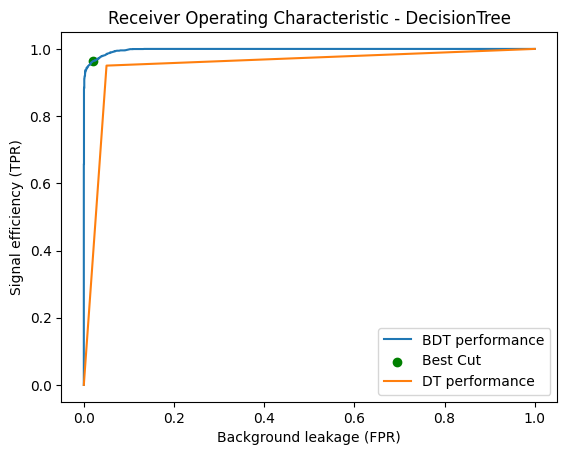

In [11]:
# Pre-defined False Positive Rate (FPR) and True Positive Rate (TPR) for the Decision Tree (DT) model
DT_FPR = [0., 0.05033557, 1.] 
DT_TPR = [0., 0.95033113, 1.]

# Obtain decision function scores for all samples in the dataset
Y_prob_all = model.decision_function(X)

# Compute ROC curve for the Boosted Decision Tree (BDT) model using the entire dataset
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(Y, Y_prob_all, pos_label=1)  # Signal class set to 1

# Plot the ROC curve for the BDT model
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")

# Scatter plot to highlight the point corresponding to the best cut (maximized significance)
plt.scatter(background_eff_max_metric, signal_eff_max_metric, c='green', label="Best Cut")

# Plot the pre-defined ROC curve for the Decision Tree (DT) model
plt.plot(DT_FPR, DT_TPR, label="DT performance")

# Add title and axis labels to the plot
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

# Add legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()